# 0.0 Importações

In [1]:
# ! pip install --upgrade category_encoders
# ! pip install xgboost
# ! pip install lightgbm
# ! pip install --upgrade pandas
# ! pip install catboost
# ! pip install dataframe_image
# ! pip install --upgrade jinja2
# ! pip install ruamel-yaml

In [2]:
import math
import datetime 
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import pandas            as pd
import seaborn           as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score
from IPython.core.display import HTML
from IPython.display import Image
import gc
import dataframe_image as dfi
import warnings
warnings.filterwarnings("ignore")

## 0.1. Funções Auxiliares

In [3]:
def load_csv(path):
    ''' Função utilizada para carregamento dos dados'''
    df = pd.read_csv(path, low_memory=True)
    return df
    
def show_dimensions(df):
    ''' Função utilizada para obter as dimensões dos dados'''
    print(f"Number of Rows:    {df.shape[0]}")
    print(f"Number of Columns: {df.shape[1]}")
    print(f"Shape:             {df.shape}")
    return None

def show_data_types(df):
    ''' Função utilizada para obter os tipos dos dados'''
    print(df.dtypes)
    return None

def check_na(df):
    ''' Função utilizada para visualizar dados ausentes ou NaN'''
    df_aux = pd.DataFrame(df.isna().sum().sort_values(ascending=False),columns=['Quantity of Missings'])
    size = df.shape[0]
    df_aux['Percent of Missings'] = 100*df_aux/size    
    df_aux = df_aux.sort_values(by='Percent of Missings',ascending=False)
    return df_aux

def eliminate_incorrect_entries_code_gender(df):
    ''' Função utilizada para eliminar as entradas incorretas (XNA) na variável CODE_GENDER'''
    df = df[df['CODE_GENDER'] != 'XNA']
    return df
    
def change_to_binary(df,columns):
    ''' Função utilizada para tornar as variáveis especificadas como binárias'''
    for bin_feature in columns:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    return df

def show_descriptive_statistical(df):
    ''' Função utilizada para exibir informações de estatística descritiva'''
    # Central Tendency - mean, median
    ct1 = pd.DataFrame(df.apply(np.mean)).T
    ct2 = pd.DataFrame(df.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(df.apply(np.std)).T
    d2 = pd.DataFrame(df.apply(min)).T
    d3 = pd.DataFrame(df.apply(max)).T
    d4 = pd.DataFrame(df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(df.apply(lambda x: x.kurtosis())).T

    df_descriptive = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    df_descriptive.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return df_descriptive

def drop_id_column(df):
    ''' Função utilizada para dropar a coluna ID'''
    df.drop(columns=['SK_ID_CURR'],inplace=True)
    return df

def one_hot_encoder(df, nan_as_category = True):
    original_columns    = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df                  = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns         = [column for column in df.columns if column not in original_columns]
    return df, new_columns

def numeric_category_dataframe(df):
    numeric_columns     = df.describe().columns.to_list()
    category_columns    = df.drop(columns=numeric_columns).columns
    numeric_dataframe   = df[numeric_columns]
    category_dataframe  = df[category_columns]
    return numeric_dataframe, category_dataframe
    
def jupyter_settings():
    ''' Função utilizada para configurar o notebook'''
    %matplotlib inline
    #%pylab inline
    
    #plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [8, 5]
    plt.rcParams['font.size'] = 24
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    mpl.rcParams['font.family'] = 'Arial'
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    return

In [4]:
# Configurando o notebook
jupyter_settings()

## 0.2. Definição dos Caminhos

In [5]:
path                       = './data/train.csv'
path_bureau                = './data/bureau.csv'
path_bureau_balance        = './data/bureau_balance.csv'
path_credit_card_balance   = './data/credit_card_balance.csv'
path_installments_payments = './data/installments_payments.csv'
path_POS_CASH_balance      = './data/POS_CASH_balance.csv'
path_previous_application  = './data/previous_application.csv'
path_test                  = './data/test.csv'

## 0.3. Carregamento dos Dados

In [6]:
data                       = load_csv(path)
data_bureau                = load_csv(path_bureau)
data_bureau_balance        = load_csv(path_bureau_balance)
data_credit_card_balance   = load_csv(path_credit_card_balance)
data_installments_payments = load_csv(path_installments_payments)
data_POS_CASH_balance      = load_csv(path_POS_CASH_balance)
data_previous_application  = load_csv(path_previous_application)
data_test                  = load_csv(path_test)

## 0.4 Modelagem dos Dados

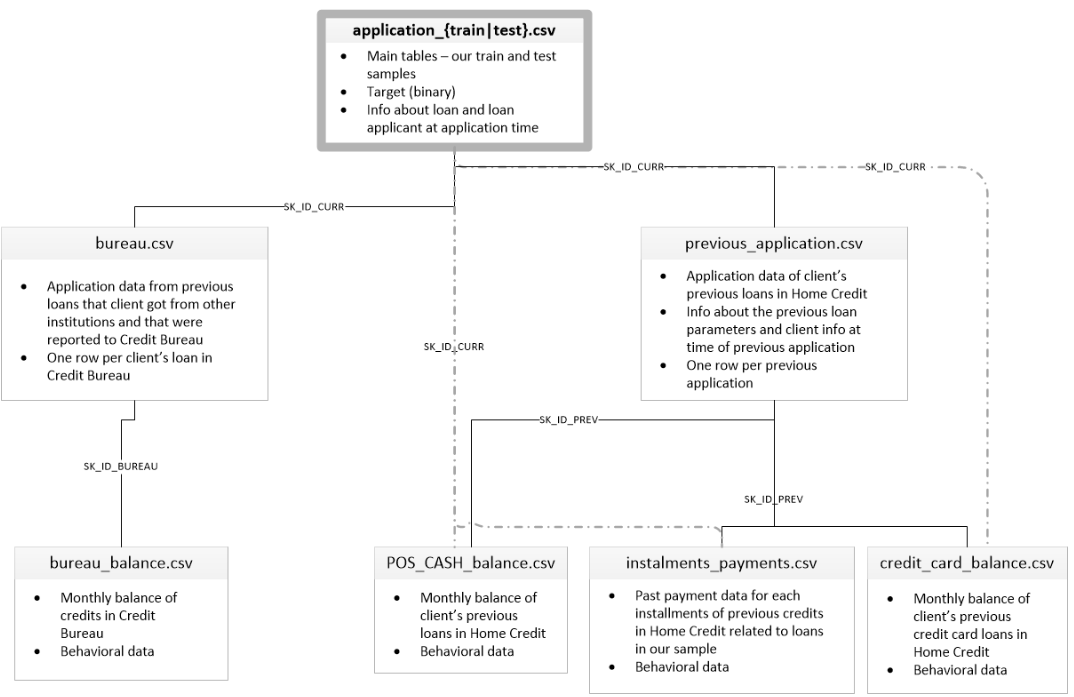

In [7]:
Image('images\data.png')

## 0.5 Agregações e JOINS entre os DataFrames

### 0.5.1 Bureau e Bureau Balance

In [8]:
data_bureau_balance , data_bureau_balance_cat    = one_hot_encoder(data_bureau_balance, nan_as_category=True)
data_bureau         , data_bureau_cat            = one_hot_encoder(data_bureau, nan_as_category=True)

# Bureau balance: Realização de agregações e o merge com bureau.csv

data_bureau_balance_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in data_bureau_balance_cat:
    data_bureau_balance_aggregations[col] = ['mean']

# Aplicação das agregações agrupadas por SK_ID_BUREAU
data_bureau_balance_aggregations = data_bureau_balance.groupby('SK_ID_BUREAU').agg(data_bureau_balance_aggregations)

# Renomeando as colunas desse DataFrame
data_bureau_balance_aggregations.columns = pd.Index([i[0] + "_" + i[1].upper() for i in data_bureau_balance_aggregations.columns])

# Merge entre DataFrames
data_bureau = data_bureau.join(data_bureau_balance_aggregations, how='left', on='SK_ID_BUREAU')

data_bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
del data_bureau_balance, data_bureau_balance_aggregations
gc.collect()

# -------------------- Agregações Numéricas ---------------------- #
num_aggregations = {
                    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
                    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
                    'DAYS_CREDIT_UPDATE': ['mean'],
                    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
                    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
                    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
                    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
                    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
                    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
                    'AMT_ANNUITY': ['max', 'mean'],
                    'CNT_CREDIT_PROLONG': ['sum'],
                    'MONTHS_BALANCE_MIN': ['min'],
                    'MONTHS_BALANCE_MAX': ['max'],
                    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}

# -------------------- Agregações Categóricas ---------------------- #
cat_aggregations = {}
for cat in data_bureau_cat: cat_aggregations[cat] = ['mean']
for cat in data_bureau_balance_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

# -------------------- Aplicando ambas as Agregações --------------- #
bureau_agg = data_bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BURO_' + i[0] + "_" + i[1].upper() for i in bureau_agg.columns.tolist()])

# -------------------- Aplicando Agregações Numéricas nos dados referentes ao Bureau ------------ #

# Condição Active Credits
active = data_bureau[data_bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + i[0] + "_" + i[1].upper() for i in active_agg.columns.tolist()])
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')

del active, active_agg
gc.collect()

# Condição Closed Credits
closed = data_bureau[data_bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + i[0] + "_" + i[1].upper() for i in closed_agg.columns.tolist()])
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

del closed, closed_agg, data_bureau
gc.collect()

0

### 0.5.2 Previous Application

In [9]:
data_previous_application, cat_cols = one_hot_encoder(data_previous_application, nan_as_category= True)

# Criação de feature: percentual entre valor solicitado / valor recebido
data_previous_application['APP_CREDIT_PERC'] = data_previous_application['AMT_APPLICATION'] / data_previous_application['AMT_CREDIT'] 
data_previous_application['APP_CREDIT_PERC'] = data_previous_application['APP_CREDIT_PERC'].apply(lambda x: x if x != np.abs(np.inf) else 0)

# -------------------- Agregações Numéricas ---------------------- #
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
}

# -------------------- Agregações Categóricas ---------------------- #
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

# -------------------- Aplicando ambas as Agregações --------------- #
prev_agg = data_previous_application.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + i[0] + "_" + i[1].upper() for i in prev_agg.columns.tolist()])

# -------------------- Aplicando Agregações Numéricas nos dados referentes ao Previous Application ------------ #
# Condição NAME_CONTRACT_STATUS_Approved == 1
approved = data_previous_application[data_previous_application['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + i[0] + "_" + i[1].upper() for i in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

# -------------------- Aplicando Agregações Numéricas nos dados referentes ao Previous Application ------------ #
# Condição NAME_CONTRACT_STATUS_Refused == 1
refused = data_previous_application[data_previous_application['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + i[0] + "_" + i[1].upper() for i in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

del refused, refused_agg, approved, approved_agg, data_previous_application
gc.collect()

0

### 0.5.3 POS CASH Balance

In [10]:
pos, cat_cols = one_hot_encoder(data_POS_CASH_balance, nan_as_category= True)

# ------------------ Agregações------------------------ #
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
for cat in cat_cols:
    aggregations[cat] = ['mean']

# ------------------ Aplicação das agregações --------- #
pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + i[0] + "_" + i[1].upper() for i in pos_agg.columns.tolist()])

# Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
del pos
gc.collect()

0

### 0.5.4 Installments payments

In [11]:
data_installments_payments, cat_cols = one_hot_encoder(data_installments_payments, nan_as_category= True)
# Percentage and difference paid in each installment (amount paid and installment value)
data_installments_payments['PAYMENT_PERC'] = data_installments_payments['AMT_PAYMENT'] / data_installments_payments['AMT_INSTALMENT']
data_installments_payments['PAYMENT_PERC'] = data_installments_payments['PAYMENT_PERC'].apply(lambda x: x if x != np.abs(np.inf) else 0)
data_installments_payments['PAYMENT_DIFF'] = data_installments_payments['AMT_INSTALMENT'] - data_installments_payments['AMT_PAYMENT']
# Days past due and days before due (no negative values)
data_installments_payments['DPD'] = data_installments_payments['DAYS_ENTRY_PAYMENT'] - data_installments_payments['DAYS_INSTALMENT']
data_installments_payments['DBD'] = data_installments_payments['DAYS_INSTALMENT'] - data_installments_payments['DAYS_ENTRY_PAYMENT']
data_installments_payments['DPD'] = data_installments_payments['DPD'].apply(lambda x: x if x > 0 else 0)
data_installments_payments['DBD'] = data_installments_payments['DBD'].apply(lambda x: x if x > 0 else 0)
# Features: Perform aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean', 'sum'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
}

for cat in cat_cols:
    aggregations[cat]     = ['mean']
ins_agg = data_installments_payments.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INSTAL_' + i[0] + "_" + i[1].upper() for i in ins_agg.columns.tolist()])
# Count installments accounts
ins_agg['INSTAL_COUNT'] = data_installments_payments.groupby('SK_ID_CURR').size()
del data_installments_payments
gc.collect()

0

### 0.5.5 Credit Card Balance

In [12]:
data_credit_card_balance, cat_cols = one_hot_encoder(data_credit_card_balance, nan_as_category= True)
# General aggregations
data_credit_card_balance.drop(['SK_ID_PREV'], axis= 1, inplace = True)
cc_agg = data_credit_card_balance.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + i[0] + "_" + i[1].upper() for i in cc_agg.columns.tolist()])
# Count credit card lines
cc_agg['CC_COUNT'] = data_credit_card_balance.groupby('SK_ID_CURR').size()
del data_credit_card_balance
gc.collect()

0

### 0.5.6 JOIN DataFrames

In [13]:
data = data.join(bureau_agg, how='left', on='SK_ID_CURR')
del bureau_agg
gc.collect()
data = data.join(prev_agg, how='left', on='SK_ID_CURR')
del prev_agg
gc.collect()
data = data.join(pos_agg, how='left', on='SK_ID_CURR')
del pos_agg
gc.collect()
data = data.join(ins_agg, how='left', on='SK_ID_CURR')
del ins_agg
gc.collect()
data = data.join(cc_agg, how='left', on='SK_ID_CURR')
del cc_agg
gc.collect()

0

# 1.0. DESCRIÇÃO DOS DADOS

In [14]:
pd.read_csv('./data/HomeCredit_columns_description.csv',encoding='latin1')

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


## 1.1 Dimensões dos Dados

In [15]:
show_dimensions(data)

Number of Rows:    307511
Number of Columns: 672
Shape:             (307511, 672)


## 1.2 Tipos dos Dados

In [16]:
show_data_types(data)

SK_ID_CURR                                                                 int64
TARGET                                                                     int64
NAME_CONTRACT_TYPE                                                        object
CODE_GENDER                                                               object
FLAG_OWN_CAR                                                              object
FLAG_OWN_REALTY                                                           object
CNT_CHILDREN                                                               int64
AMT_INCOME_TOTAL                                                         float64
AMT_CREDIT                                                               float64
AMT_ANNUITY                                                              float64
AMT_GOODS_PRICE                                                          float64
NAME_TYPE_SUITE                                                           object
NAME_INCOME_TYPE            

## 1.3 Checar NaN

In [17]:
df_aux = check_na(data)
df_aux.head(25)

,Quantity of Missings,Percent of Missings
REFUSED_AMT_DOWN_PAYMENT_MIN,262341,85.311095
REFUSED_AMT_DOWN_PAYMENT_MEAN,262341,85.311095
REFUSED_RATE_DOWN_PAYMENT_MIN,262341,85.311095
REFUSED_RATE_DOWN_PAYMENT_MAX,262341,85.311095
REFUSED_RATE_DOWN_PAYMENT_MEAN,262341,85.311095
REFUSED_AMT_DOWN_PAYMENT_MAX,262341,85.311095
REFUSED_APP_CREDIT_PERC_VAR,258350,84.013255
CC_AMT_PAYMENT_CURRENT_VAR,246892,80.287209
CC_CNT_DRAWINGS_ATM_CURRENT_VAR,246818,80.263145
CC_AMT_DRAWINGS_OTHER_CURRENT_VAR,246818,80.263145


Variavéis com 80% ou mais de dados faltantes serão descartadas para modelagem.

In [18]:
# Lista das variáveis que serão mantidas 
vars = (df_aux[df_aux['Percent of Missings'] < 80]).index.to_list()
print('Número de variáveis descartadas:{}'.format(data.shape[1] - len(vars)))

# Atualização do DataFrame
data = data[vars]

del vars
gc.collect()

Número de variáveis descartadas:37


0

## 1.4 Eliminar dados incorretos na variável CODE_GENDER

In [19]:
data = eliminate_incorrect_entries_code_gender(data)

## 1.5 Tornar `CODE_GENDER`, `FLAG_OWN_CAR`, `FLAG_OWN_REALTY` variáveis binárias

In [20]:
# Variáveis a serem transformadas em binárias
variables = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
data = change_to_binary(data,variables)

del variables
gc.collect()

0

## 1.6 Estatística Descritiva

In [21]:
num_attributes = data.select_dtypes(include=['int32', 'int8', 'int64', 'float64', 'float32', 'float16'])
cat_attributes = data.select_dtypes(exclude=['int32', 'int8', 'int64', 'float64', 'float32', 'float16', 'datetime64[ns]'])

### 1.6.1 Atributos Numéricos

In [22]:
show_descriptive_statistical(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,CLOSED_AMT_ANNUITY_MAX,0.000000e+00,5.958668e+07,5.958668e+07,2.921818e+04,NaN,4.898765e+05,88.753047,9399.979089
1,CLOSED_AMT_ANNUITY_MEAN,0.000000e+00,5.456266e+07,5.456266e+07,1.583601e+04,NaN,2.686436e+05,145.971216,27101.084628
2,ACTIVE_MONTHS_BALANCE_MAX_MAX,-9.100000e+01,0.000000e+00,9.100000e+01,-9.438048e-01,NaN,5.579637e+00,-8.590777,89.302428
3,ACTIVE_MONTHS_BALANCE_SIZE_MEAN,1.000000e+00,9.700000e+01,9.600000e+01,1.809577e+01,NaN,1.347974e+01,1.755337,4.641012
4,ACTIVE_MONTHS_BALANCE_MIN_MIN,-9.600000e+01,0.000000e+00,9.600000e+01,-2.945846e+01,NaN,2.246034e+01,-1.008184,0.448142
5,BURO_AMT_ANNUITY_MEAN,0.000000e+00,2.728243e+07,2.728243e+07,1.605225e+04,NaN,1.705005e+05,104.925600,14184.620903
6,BURO_AMT_ANNUITY_MAX,0.000000e+00,5.958668e+07,5.958668e+07,3.483845e+04,NaN,5.146581e+05,87.227203,8815.922202
7,CLOSED_MONTHS_BALANCE_MIN_MIN,-9.600000e+01,0.000000e+00,9.600000e+01,-5.998370e+01,NaN,2.579317e+01,0.320212,-1.140132
8,CLOSED_MONTHS_BALANCE_SIZE_MEAN,1.000000e+00,9.700000e+01,9.600000e+01,3.345759e+01,NaN,1.903166e+01,0.756365,0.296051
9,CLOSED_MONTHS_BALANCE_MAX_MAX,-9.400000e+01,0.000000e+00,9.400000e+01,-3.605760e+00,NaN,1.155348e+01,-4.145276,18.728691


### 1.5.2 Atributos Categóricos

In [23]:
# Verificar a quantidade de itens únicos em cada variável categórica
cat_attributes.apply(lambda x: x.unique().shape[0])

FONDKAPREMONT_MODE             5
WALLSMATERIAL_MODE             8
HOUSETYPE_MODE                 4
EMERGENCYSTATE_MODE            3
OCCUPATION_TYPE               19
NAME_TYPE_SUITE                8
ORGANIZATION_TYPE             58
WEEKDAY_APPR_PROCESS_START     7
NAME_CONTRACT_TYPE             2
NAME_HOUSING_TYPE              6
NAME_FAMILY_STATUS             6
NAME_EDUCATION_TYPE            5
NAME_INCOME_TYPE               8
dtype: int64

## 2. Análise Exploratória dos Dados

### 2.1 Análise Univariada dos Dados

#### 2.1.1 Variável Alvo (TARGET)

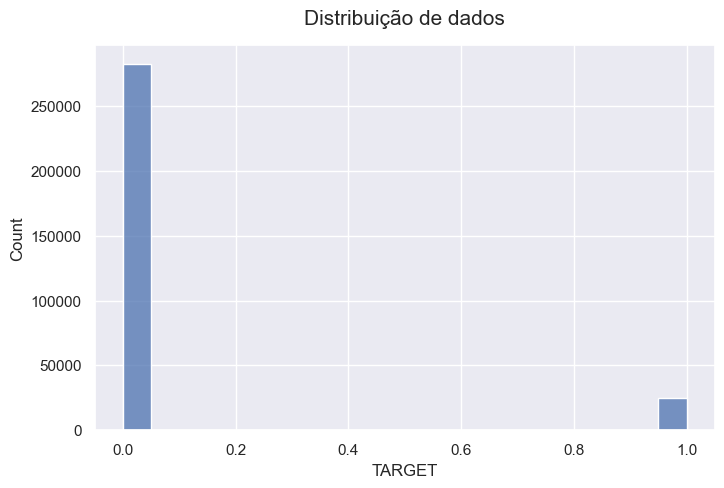

In [24]:
sns.histplot(data['TARGET'])
plt.title('Distribuição de dados',size=15,pad=15);

Nota-se um claro desbalanceamento nos dados em relação à variável alvo.

### 2.2 Análise Bivariada


#### Existe alguma diferença entre os bons e maus pagadores em função da renda?

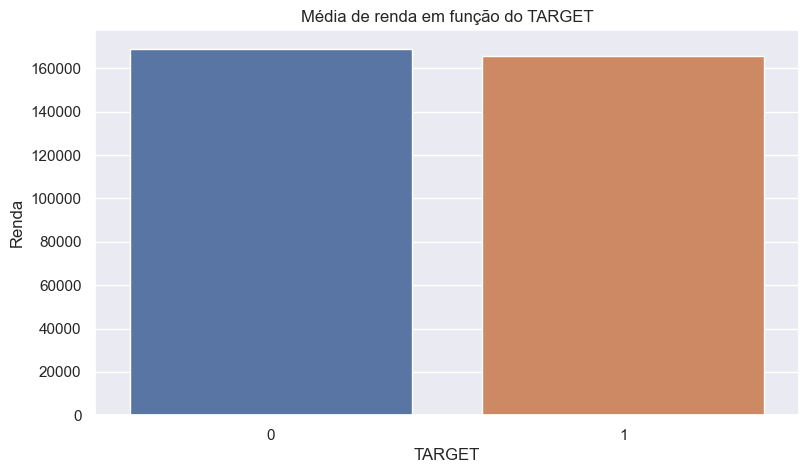

In [25]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('TARGET').AMT_INCOME_TOTAL.mean().index,y=data.groupby('TARGET').AMT_INCOME_TOTAL.mean().values);
plt.title('Média de renda em função do TARGET');
plt.ylabel('Renda');

#### Existe alguma diferença entre os bons e maus pagantes em função do gênero?

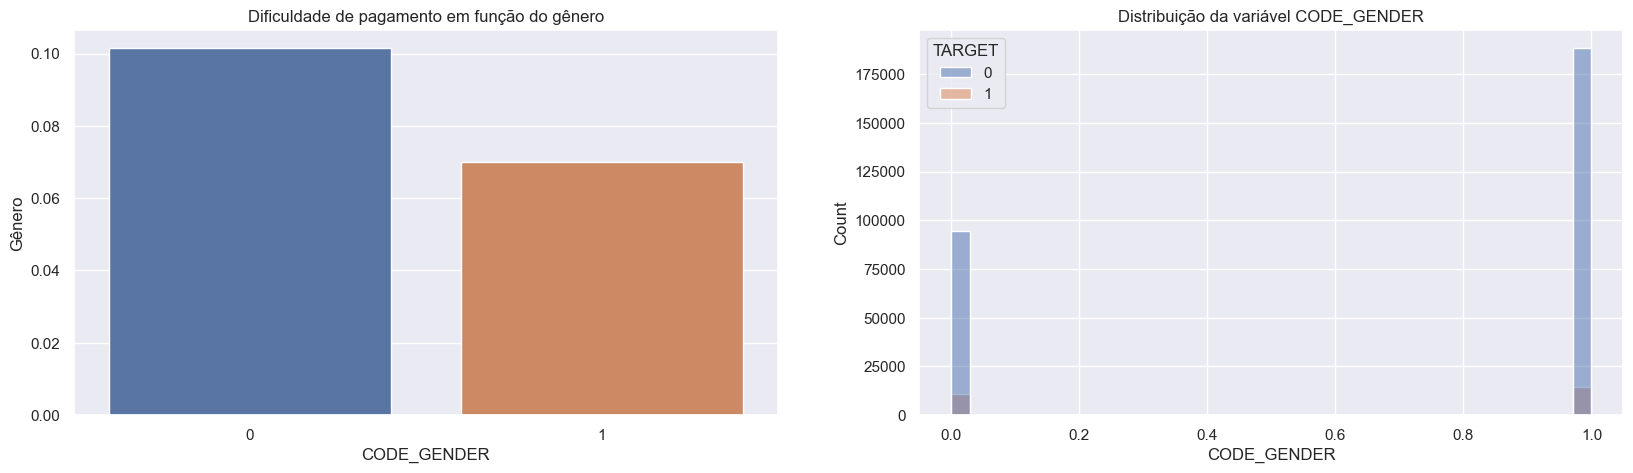

In [26]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.barplot(x=data.groupby('CODE_GENDER').TARGET.mean().index,y=data.groupby('CODE_GENDER').TARGET.mean().values);
plt.title('Dificuldade de pagamento em função do gênero');
plt.ylabel('Gênero')

plt.subplot(1, 2, 2)
sns.histplot(data=data, x='CODE_GENDER',hue='TARGET')
plt.title('Distribuição da variável CODE_GENDER');

No gráfico à esquerda, podemos notar a dificuldade de pagamento (TARGET = 0 e TARGET = 1) em função do gênero. No gráfico à direita, notamos a distribuição para a variável `CODE_GENDER`.

Verifica-se que:
* A quantidade de homens que tiveram dificuldade de pagamento (TARGET = 1) foi maior que a quantidade de mulheres.

# 3. Preparação dos Dados

## 3.1 Criação de Novas Features

In [27]:
# Criação de novas features
data['DAYS_EMPLOYED_PERC']  = (data['DAYS_EMPLOYED']    / data['DAYS_BIRTH']).apply(lambda x: x if x != np.abs(np.inf) else 0)
data['INCOME_CREDIT_PERC']  = (data['AMT_INCOME_TOTAL'] / data['AMT_CREDIT']).apply(lambda x: x if x != np.abs(np.inf) else 0)
data['INCOME_PER_PERSON']   = (data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']).apply(lambda x: x if x != np.abs(np.inf) else 0)
data['ANNUITY_INCOME_PERC'] = (data['AMT_ANNUITY']      / data['AMT_INCOME_TOTAL']).apply(lambda x: x if x != np.abs(np.inf) else 0)
data['PAYMENT_RATE']        = (data['AMT_ANNUITY']      / data['AMT_CREDIT']).apply(lambda x: x if x != np.abs(np.inf) else 0)

## 3.2 Split dos Dados

In [28]:
X = data.drop(columns=['TARGET'])
y = data.TARGET
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

del data, X, y
gc.collect()

6919

In [29]:
num_attributes = X_train.select_dtypes(include=['int32', 'int8', 'int64', 'float64', 'float32', 'float16'])
cat_attributes = X_train.select_dtypes(exclude=['int32', 'int8', 'int64', 'float64', 'float32', 'float16', 'datetime64[ns]'])

## 3.3 Pipeline de Imputações de Dados e Encoding

In [30]:
# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('imputer', SimpleImputer(strategy='constant',fill_value=0)),
    ('encoder', TargetEncoder())
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
    # ('imputer', SimpleImputer(strategy='mean'))
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_attributes.columns),
    ('num', num_pipe, num_attributes.columns)
])

# 4. Modelo de Machine Learning

## 4.1 Feature Selection

Quantidade de features no conjunto de dados inicial: 639
Quantidade de features selecionadas: 589


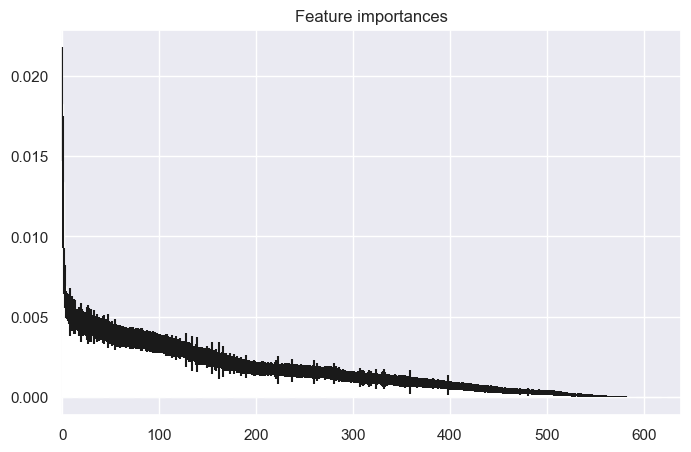

In [31]:
pipe_feature_importances = Pipeline([
                            ('preprocessor', preprocessor),
                            ('model', RandomForestClassifier())
])

pipe_feature_importances.fit(X_train, y_train)

importances = pipe_feature_importances['model'].feature_importances_
std         = np.std([tree.feature_importances_ for tree in pipe_feature_importances['model'].estimators_],
             axis=0)
indices     = np.argsort(importances)[::-1]

indices_selected_features=[]

for f in range(X_train.shape[1]):
    if importances[indices[f]] > 0: 
        indices_selected_features.append(indices[f])

print('Quantidade de features no conjunto de dados inicial: {}'.format(X_train.shape[1]))
print('Quantidade de features selecionadas: {}'.format(len(indices_selected_features)))

# Plot the feature importances of the forest
plt.figure(1, figsize=(8, 5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
# plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [32]:
# Lista das 10 Features mais importantes
indices_selected_features_top10 = indices_selected_features[:10]

# Exibir as 10 features mais importantes
print(X_train.columns[indices_selected_features_top10].to_list())

['FLAG_DOCUMENT_20', 'BURO_CREDIT_TYPE_Mortgage_MEAN', 'APARTMENTS_MODE', 'NAME_EDUCATION_TYPE', 'REGION_POPULATION_RELATIVE', 'NAME_HOUSING_TYPE', 'ANNUITY_INCOME_PERC', 'DAYS_EMPLOYED_PERC', 'BURO_CREDIT_ACTIVE_Bad debt_MEAN', 'SK_ID_CURR']


In [33]:
# Atualização do X_train e X_test com base em todas as features selecionadas
X_train = X_train[X_train.columns[indices_selected_features]]
X_test  = X_test[X_test.columns[indices_selected_features]]

In [34]:
num_attributes = X_train.select_dtypes(include=['int32', 'int8', 'int64', 'float64', 'float32', 'float16'])
cat_attributes = X_train.select_dtypes(exclude=['int32', 'int8', 'int64', 'float64', 'float32', 'float16', 'datetime64[ns]'])

In [35]:
del indices_selected_features_top10, indices, indices_selected_features, pipe_feature_importances, importances, cat_pipe, num_pipe, preprocessor
gc.collect()

50281

## 4.3 Seleção do Modelo de Machine Learning

Modelos testados:

* LogisticRegression;
* RandomForestClassifier;
* XGBClassifier;
* lgb.LGBMClassifier;
* CatBoostClassifier

In [36]:
classifiers = [
    LogisticRegression(class_weight='balanced'),
    RandomForestClassifier(class_weight='balanced'),
    XGBClassifier(),
    lgb.LGBMClassifier(class_weight='balanced'),
    CatBoostClassifier(verbose=False)
]

# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('imputer', SimpleImputer(strategy='constant',fill_value=0)),
    ('encoder', TargetEncoder())
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
    # ('imputer', SimpleImputer(strategy='mean'))
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_attributes.columns),
    ('num', num_pipe, num_attributes.columns)
])

results = []
for classifier in classifiers:
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier)])
    pipe.fit(X_train, y_train)
    ypred = pipe.predict(X_test)
    y_pred_prob = pipe.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test,y_pred_prob)
    results.append(roc_auc)
    print(classifier)
    print("model score: %.4f" % pipe.score(X_test, y_test))
    print("model roc_auc_score: %.4f" % roc_auc)
    print("model classification report")
    print(classification_report(y_test, ypred))

del roc_auc, classifiers, cat_pipe, num_pipe, preprocessor
gc.collect()

LogisticRegression(class_weight='balanced')
model score: 0.7062
model roc_auc_score: 0.7732
model classification report
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     56578
           1       0.17      0.70      0.28      4924

    accuracy                           0.71     61502
   macro avg       0.57      0.70      0.55     61502
weighted avg       0.90      0.71      0.77     61502

RandomForestClassifier(class_weight='balanced')
model score: 0.9199
model roc_auc_score: 0.7379
model classification report
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56578
           1       0.50      0.00      0.00      4924

    accuracy                           0.92     61502
   macro avg       0.71      0.50      0.48     61502
weighted avg       0.89      0.92      0.88     61502

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, col

96

In [37]:
# Comparação entre a métrica ROC-AUC para os diversos modelos
df_roc_auc = pd.DataFrame(results,index=['LogisticRegression','Random Forest','XGBoost','LightGBM','Catboost'],columns=['ROC-AUC']).sort_values(by='ROC-AUC',ascending=False)
df_roc_auc

,ROC-AUC
Catboost,0.791117
LightGBM,0.788879
XGBoost,0.779097
LogisticRegression,0.773240
Random Forest,0.737862


In [38]:
# Exportando imagem 
dfi.export(df_roc_auc, 'dataframe_roc_auc.png')

del df_roc_auc
gc.collect()

59

## 4.4 Ajustando Threshold

In [39]:
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

# evaluate each threshold
scores          = np.array([f1_score(y_test, to_labels(y_pred_prob, t)) for t in thresholds])
best            = np.where(scores == scores.max())[0][0]
best_thresholds = thresholds[best]
best_scores     = scores[best]

## 4.5 Desempenho do modelo após ajuste no Threshold

In [40]:
ypred[y_pred_prob >= best_thresholds] = 1
ypred[y_pred_prob < best_thresholds]  = 0
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     56578
           1       0.27      0.46      0.34      4924

    accuracy                           0.86     61502
   macro avg       0.61      0.68      0.63     61502
weighted avg       0.90      0.86      0.87     61502



# 5. Salvando Modelo em Pickle

In [43]:
# ----------------------- Exportando o modelo com melhor resultado ----------------------- #

# Exportando o modelo final para implantação
import pickle

pickle.dump(pipe, open('./models/pipe.pkl', 'wb'))